# ¿Se puede medir el bienestar de un país en función de las emociones encontradas en las canciones más escuchadas? (Análisis Descriptivo Robusto)
* Actividad 2 Grupal del CUA de Data Analyst, Análisis e Interpretación de Datos, UNIR 2023
    * Realizado por:
            * David Toscano Recalde
            * Nicolás Felipe Trujillo Montero
            * Iris Aguado Fernández

## Descripción
Nuestro objetivo es realizar un análisis tomando de muestra aleatoria de personas de EEUU para observar si existe una relación entre la canción más escuchada en un país y la situación económica del país. Para ello, partiremos de una serie de datos y realizaremos un par de análisis descriptivos, uno general y uno robusto para llegar a una conclusión. 

Los datos son los siguientes:
* Top 1 de Spotify (charts.csv): Se trata de un dataframe completo de todas las canciones top 200 y virales 50 gráficos publicados globalmente por Spotify. (Fuente: https://www.kaggle.com/datasets/dhruvildave/spotify-charts?resource=download)
* Lista de Canciones junto con Emocion asociadas (muse_v3.csv): Se trata de un dataframe que asocia 90.000 canciones con una emoción asociada a la canción en función de la letra de la canción. (Fuente: https://www.kaggle.com/code/cakiki/muse-dataset-getting-started/data)
* Datos Macroeconómicos a nivel Estados Unidos (DP_LIVE.csv): Se trata de un dataframe que por cada mes nos indica los indicadores del país. (Fuente: https://databank.worldbank.org/reports.aspx?source=world-development-indicators#)

## Importamos librerías y Datos

In [1]:
######################################################
# Tratamiento de Datos
######################################################
import pandas as pd
import numpy as np
from datetime import datetime
import re
from scipy.stats import trim_mean
from sklearn.linear_model import LinearRegression
from sklearn import metrics

######################################################
# Gráficos
######################################################
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# DF Top Spotify
df_top_original = pd.read_csv("charts.csv")  

# DF Etiquetas X Cancion
df_labels_original = pd.read_csv("muse_v3.csv")

# DF Variables Macroec
economic_df_original = pd.read_csv("DP_LIVE.csv")

## Depuración y Filtración para hacer el análisis

1.- Nos quedamos con el top 1 de solo nuestro tamaño de la muestra, es decir, Estados Unidos

NOTA: El valor de streams es NaN cuando la columna chart es "viral50".

In [3]:
#Leemos en data set, y eliminamos los datos que sean de otros paises
df_top = pd.read_csv("charts.csv")
condicion=df_top["region"]=="United States"
df_top = df_top[condicion]
#df_top contiene un listado de canciones del top200 de spotify DIARIO

2.- Realizamos un filtrado para poder juntar df_top con df_labels.

In [4]:
df_labels = df_labels_original.copy()

# Cambiamos la columna track por title para poder juntarlo con df_top
df_labels.rename(columns = {'track':'title'}, inplace = True)

# Tenemos que ver si hay valores NA, y si los hay ver si nos merece la pena eliminarlos.
print(df_labels.count())
display(df_labels["genre"])

lastfm_url                90001
title                     90001
artist                    90001
seeds                     90001
number_of_emotion_tags    90001
valence_tags              90001
arousal_tags              90001
dominance_tags            90001
mbid                      61217
spotify_id                61630
genre                     83362
dtype: int64


0                     rap
1                   metal
2                     rap
3                 hip-hop
4                   metal
               ...       
89996                 NaN
89997    progressive rock
89998                 NaN
89999                 NaN
90000             ambient
Name: genre, Length: 90001, dtype: object

In [5]:
df_labels.drop(df_labels[df_labels['genre'].isna()].index, inplace = True)
display(df_labels.count())

lastfm_url                83362
title                     83362
artist                    83362
seeds                     83362
number_of_emotion_tags    83362
valence_tags              83362
arousal_tags              83362
dominance_tags            83362
mbid                      58559
spotify_id                58687
genre                     83362
dtype: int64

In [6]:
df_merged = pd.merge(df_labels,df_top,how="inner", on = "title")
df_merged.drop(['mbid','spotify_id'], axis=1)
df_merged['date'] = pd.to_datetime(df_merged['date'],format="%Y-%m-%d")
df_merged["year"]=df_merged["date"].dt.year
df_merged["month"]=df_merged["date"].dt.month
df_merged.rename(columns = {'region':'COUNTRY'}, inplace = True)
display(df_merged.count())

lastfm_url                284803
title                     284803
artist_x                  284803
seeds                     284803
number_of_emotion_tags    284803
valence_tags              284803
arousal_tags              284803
dominance_tags            284803
mbid                      210823
spotify_id                247773
genre                     284803
rank                      284803
date                      284803
artist_y                  284803
url                       284803
COUNTRY                   284803
chart                     284803
trend                     284803
streams                   228728
year                      284803
month                     284803
dtype: int64

3.- Realizamos un filtrado de US_SECONOMICS 

In [7]:
economic_df = economic_df_original.copy()

# El data set de economia contien datos deiferentes medidos de forma diferente, por ello a continuacion se describe como deseamos los datos
#["SUBJECT"]=="TOT"] significa que queremos la medicion total, no solo en hombres ni solo en mujeres, sino total 
#["FREQUENCY"]=="M"] definimos para obtener la medida de forma mensual, A significari anual por ejemplo
economic_df= economic_df[(economic_df["LOCATION"]=="USA") & (economic_df["SUBJECT"]=="TOT") & (economic_df["FREQUENCY"]=="M")]

economic_df['date'] = pd.to_datetime(economic_df['TIME'],format="%Y-%m")
economic_df["year"]=economic_df["date"].dt.year
economic_df["month"]=economic_df["date"].dt.month
economic_df.tail()

,LOCATION,INDICATOR,SUBJECT,MEASURE,FREQUENCY,TIME,Value,Flag Codes,date,year,month
18904,USA,HUR,TOT,PC_LF,M,2022-08,3.7,NaN,2022-08-01,2022,8
18905,USA,HUR,TOT,PC_LF,M,2022-09,3.5,NaN,2022-09-01,2022,9
18906,USA,HUR,TOT,PC_LF,M,2022-10,3.7,NaN,2022-10-01,2022,10
18907,USA,HUR,TOT,PC_LF,M,2022-11,3.6,NaN,2022-11-01,2022,11
18908,USA,HUR,TOT,PC_LF,M,2022-12,3.5,NaN,2022-12-01,2022,12


4.- Modificamos ambos dataframes para la union

In [8]:
# Realizamos el merge en funcion del año y mes 
df_master = pd.merge(economic_df,df_merged,how="inner", on = ["year","month"])


In [9]:
# Eliminamos algunas columnas para que el dataframe se visualize mejor 
df_master.drop(columns=['INDICATOR', 'SUBJECT', "MEASURE",
                        "lastfm_url","artist_x","url","chart","trend","FREQUENCY"	,
                        "TIME","Flag Codes","LOCATION"	,"date_x","mbid",
                        "spotify_id",	"genre"	,"date_y",
                        "number_of_emotion_tags",	"valence_tags",	"arousal_tags",	"dominance_tags",
                        "artist_y"],inplace=True)

In [10]:
# IMPORTANTE: ahora el dataframe contiene una columna que se llama "seed" la que tiene el perfil emocional de la cancion
# pero esta informacion esta en formato string, asi que primero debemos crear una columna con los adjetivos de mas importancia
# estos adjetivos los defini observando el dataframe y definiendo los mas recurrentes y  mas representativos

labels = ["angry", "aggressive",
            "romantic","optimistic","positive",
            "powerful",
            "light",
            "sad",
            "dramatic",
            "bitter",
            "smooth"]

def iscategory(x,y):
    return bool(re.search(x,y))

for word in labels:
    df_master[word]=word
    df_master[word] = df_master.apply(lambda x1: iscategory(x1[word], x1['seeds']), axis=1)
    
df_master.drop(df_master[df_master["streams"] == "NO"].index, inplace = True)

In [11]:
display(df_master.columns)

Index(['Value', 'year', 'month', 'title', 'seeds', 'rank', 'COUNTRY',
       'streams', 'angry', 'aggressive', 'romantic', 'optimistic', 'positive',
       'powerful', 'light', 'sad', 'dramatic', 'bitter', 'smooth'],
      dtype='object')

In [12]:
df_master["streams"]=df_master["streams"].astype(np.float64)

df_master = df_master.groupby(["year","month"]).agg(
    {'angry':'mean',
    'Value':'mean',
    "angry":'mean', 
    "aggressive":'mean',
    "romantic":'mean',
    "optimistic":'mean',
    "positive":'mean',
    "powerful":'mean',
    "light":'mean',
    "sad":'mean',
    "dramatic":'mean',
    "bitter":'mean',
    "smooth":'mean',
    "streams":'sum'
    })
df_master = df_master.reset_index()

In [13]:
df_master.dtypes

year            int64
month           int64
angry         float64
Value         float64
aggressive    float64
romantic      float64
optimistic    float64
positive      float64
powerful      float64
light         float64
sad           float64
dramatic      float64
bitter        float64
smooth        float64
streams       float64
dtype: object

In [14]:
df_master.head(12)

,year,month,angry,Value,aggressive,romantic,optimistic,positive,powerful,light,sad,dramatic,bitter,smooth,streams
0,2017,1,0.005325,4.7,0.014294,0.017377,0.004624,0.012752,0.021160,0.040779,0.024383,0.009950,0.037836,0.027046,1.707592e+09
1,2017,2,0.005842,4.6,0.029337,0.013716,0.005588,0.006477,0.017145,0.042037,0.027051,0.013335,0.029591,0.034290,1.725893e+09
2,2017,3,0.002849,4.4,0.022249,0.011260,0.010582,0.011260,0.020079,0.013295,0.052503,0.020621,0.028219,0.031746,2.081394e+09
3,2017,4,0.005139,4.4,0.016150,0.018499,0.006607,0.014535,0.024226,0.013214,0.037733,0.019968,0.020555,0.023198,1.975262e+09
4,2017,5,0.024734,4.4,0.013268,0.035545,0.016708,0.007371,0.017690,0.015070,0.046355,0.023260,0.015070,0.018837,1.798737e+09
5,2017,6,0.015459,4.3,0.027505,0.040956,0.011845,0.004417,0.013250,0.015660,0.043365,0.019474,0.032323,0.026902,1.444662e+09
6,2017,7,0.014717,4.3,0.021423,0.043405,0.012109,0.001863,0.008756,0.010246,0.041170,0.011364,0.030179,0.026826,1.504231e+09
7,2017,8,0.013544,4.4,0.030214,0.047925,0.006425,0.004688,0.016322,0.013370,0.038896,0.011808,0.023789,0.030214,1.612867e+09
8,2017,9,0.026703,4.3,0.023978,0.045232,0.003451,0.000000,0.014896,0.013624,0.035604,0.012352,0.027611,0.030154,1.560836e+09
9,2017,10,0.019469,4.2,0.021416,0.037345,0.008319,0.009204,0.018761,0.012566,0.036991,0.017522,0.027788,0.021416,1.450200e+09


In [15]:
def calcul_tps_medianv2(x, column):
    a=x[column].values.tolist()
    if len(a)%2==1:
        a = np.median(a)
    elif len(a)==0:
        a=0
    else:
        a= a[np.argpartition(a,int((len(a)/2)-1))[int((len(a)/2)-1)]]
    return a

In [16]:
columns_aux = list(set(df_master.columns)-set(['year', 'month', 'streams']))
df_master_filtered = []
for _year in range(2017,2022):
    df_aux = df_master[df_master['year'] == _year]
    value_median = calcul_tps_medianv2(df_aux, 'Value')
    df_aux = df_aux[df_aux['Value'] == value_median].iloc[0]
    df_aux = df_aux[columns_aux].values.ravel()
    df_master_filtered.append(df_aux)

In [17]:
df_master_res = pd.DataFrame(df_master_filtered, columns = columns_aux)

In [18]:
df_master_res.index=range(2017,2022)
df_master_res.head()

,optimistic,angry,powerful,romantic,dramatic,bitter,smooth,Value,sad,light,aggressive,positive
2017,0.011845,0.015459,0.013250,0.040956,0.019474,0.032323,0.026902,4.3,0.043365,0.015660,0.027505,0.004417
2018,0.026576,0.023344,0.038068,0.031604,0.009337,0.009337,0.028192,3.8,0.064644,0.012929,0.021907,0.005207
2019,0.004535,0.012956,0.036493,0.017491,0.004319,0.025696,0.036277,3.6,0.058087,0.011445,0.016195,0.017923
2020,0.017938,0.009396,0.018508,0.012244,0.002278,0.008257,0.006549,6.9,0.051253,0.021925,0.005125,0.009112
2021,0.010523,0.010204,0.014031,0.025191,0.000000,0.006059,0.036671,5.4,0.049426,0.000000,0.019452,0.007334


# El dataframe queda listo, usar df_master para el analisis

### A continuacion realizo unas graficas basicas exploratorias

In [19]:
display(df_master_res[['angry','sad','positive', 'optimistic','aggressive','Value']])
# sns.scatterplot(data=df_master_res,x= df_master_res.index ,y=  'happy' )
# sns.scatterplot(data=df_master_res,x= df_master_res.index ,y=  'Value' )
# #plt.legend(loc='center',bbox_to_anchor=(1.12,0.5))
# plt.show()

,angry,sad,positive,optimistic,aggressive,Value
2017,0.015459,0.043365,0.004417,0.011845,0.027505,4.3
2018,0.023344,0.064644,0.005207,0.026576,0.021907,3.8
2019,0.012956,0.058087,0.017923,0.004535,0.016195,3.6
2020,0.009396,0.051253,0.009112,0.017938,0.005125,6.9
2021,0.010204,0.049426,0.007334,0.010523,0.019452,5.4


<AxesSubplot: xlabel='Value', ylabel='positive'>

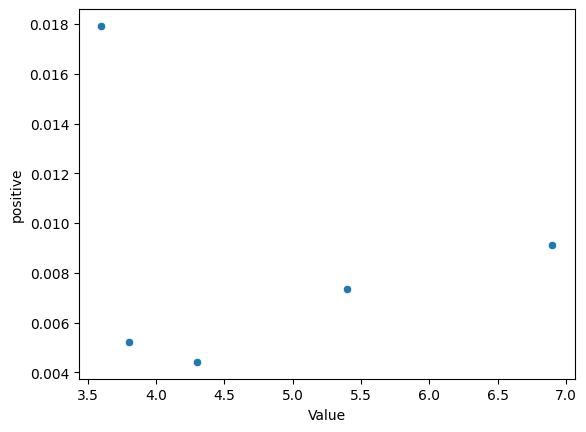

In [20]:
sns.scatterplot(data=df_master_res,x= 'Value',y= 'positive')

In [21]:
model = LinearRegression()

# Eliminamos el outlier 
df_master_res_pos = df_master_res.drop(index=(2019))
model.fit(np.array(df_master_res_pos['Value']).reshape(-1,1), df_master_res_pos['positive'])

LinearRegression()

In [22]:
prediccion = model.predict(np.array(df_master_res_pos['Value']).reshape(-1,1))
print(metrics.r2_score(df_master_res_pos['positive'], prediccion))

0.8994570907722056


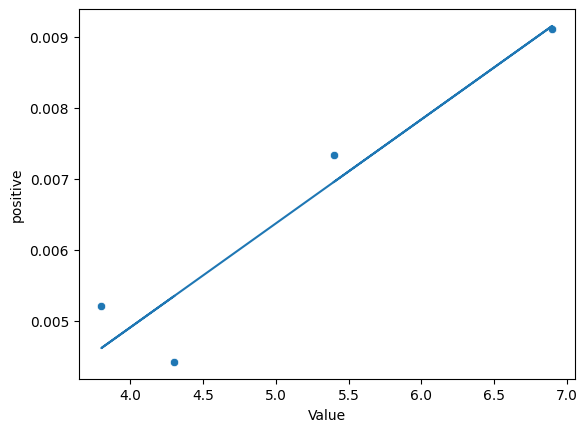

In [23]:
sns.scatterplot(data=df_master_res_pos,x= 'Value',y= 'positive')
plt.plot(df_master_res_pos['Value'], prediccion)

<AxesSubplot: xlabel='Value', ylabel='optimistic'>

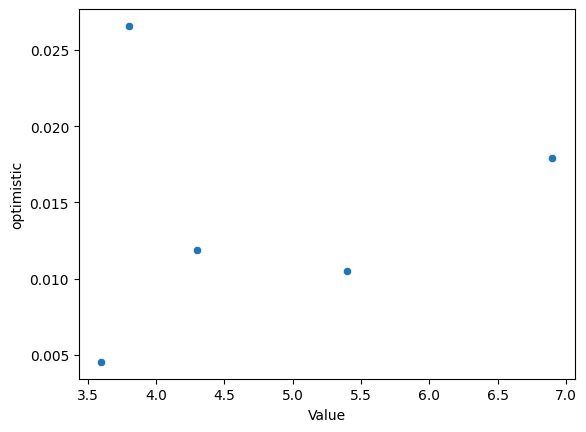

In [24]:
sns.scatterplot(data=df_master_res,x= 'Value',y= 'optimistic')

In [25]:
df_master_res_opt = df_master_res.drop(index=(2018))

model.fit(np.array(df_master_res_opt['Value']).reshape(-1,1), df_master_res_opt['optimistic'])
prediccion = model.predict(np.array(df_master_res_opt['Value']).reshape(-1,1))
print(metrics.r2_score(df_master_res_opt['optimistic'], prediccion))

0.8137769438783127


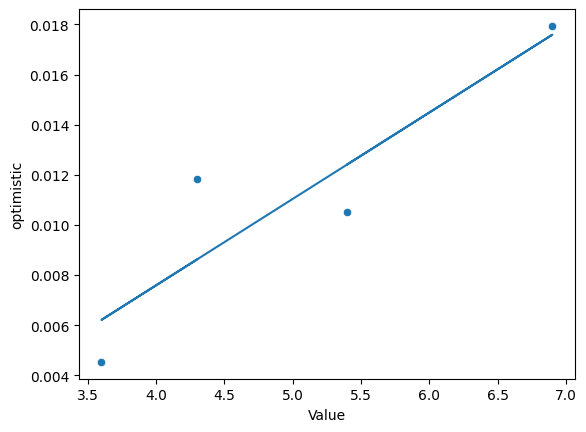

In [26]:
sns.scatterplot(data=df_master_res_opt,x= 'Value',y= 'optimistic')
plt.plot(df_master_res_opt['Value'], prediccion)

<AxesSubplot: xlabel='Value', ylabel='angry'>

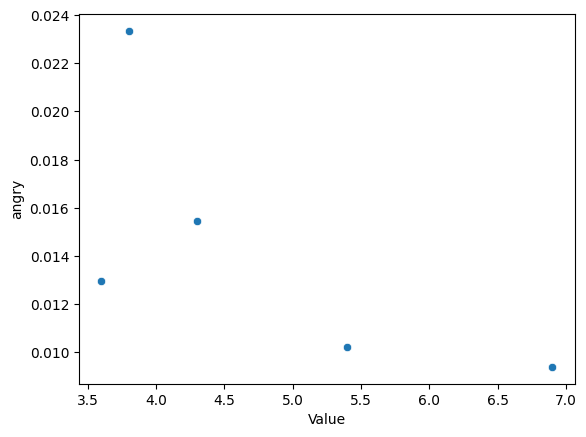

In [27]:
sns.scatterplot(data=df_master_res,x= 'Value',y= 'angry')

In [29]:
df_master_res_ang = df_master_res.drop(index=(2018))

model.fit(np.array(df_master_res_ang['Value']).reshape(-1,1), df_master_res_ang['angry'])
prediccion = model.predict(np.array(df_master_res_ang['Value']).reshape(-1,1))
print(metrics.r2_score(df_master_res_ang['angry'], prediccion))

0.6252641152419298


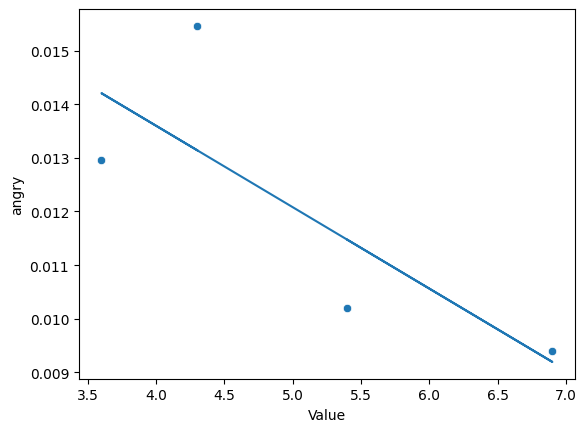

In [30]:
sns.scatterplot(data=df_master_res_ang,x= 'Value',y= 'angry')
plt.plot(df_master_res_ang['Value'], prediccion)

<AxesSubplot: xlabel='Value', ylabel='aggressive'>

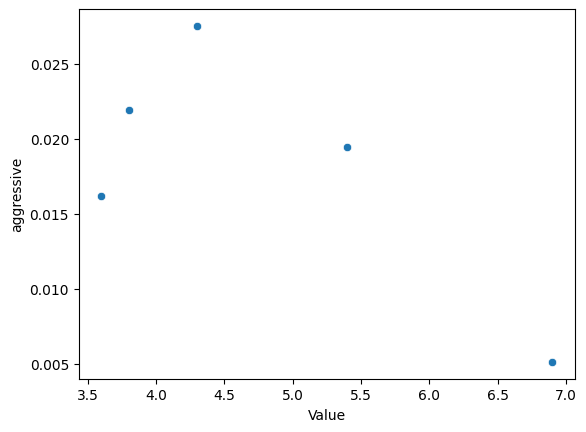

In [31]:
sns.scatterplot(data=df_master_res,x= 'Value',y= 'aggressive')

In [32]:
df_master_res_ang = df_master_res.drop(index=(2020))

model.fit(np.array(df_master_res_ang['Value']).reshape(-1,1), df_master_res_ang['aggressive'])
prediccion = model.predict(np.array(df_master_res_ang['Value']).reshape(-1,1))
print(metrics.r2_score(df_master_res_ang['aggressive'], prediccion))

0.011423683490765613


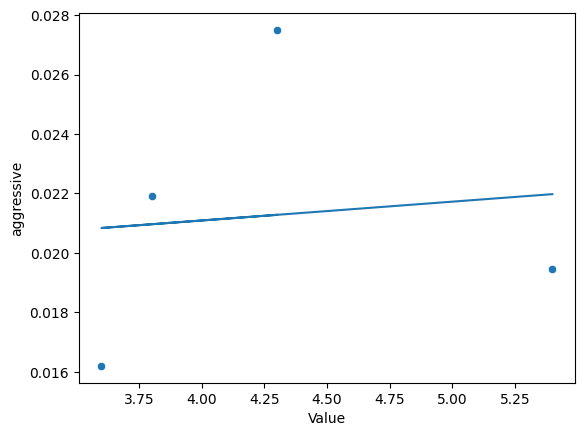

In [33]:
sns.scatterplot(data=df_master_res_ang,x= 'Value',y= 'aggressive')
plt.plot(df_master_res_ang['Value'], prediccion)

### Año 2020

In [34]:
df_master1 = df_master[df_master['year']==2020]
df_master1.head()

,year,month,angry,Value,aggressive,romantic,optimistic,positive,powerful,light,sad,dramatic,bitter,smooth,streams
36,2020,1,0.024111,3.5,0.001871,0.015174,0.023072,0.004781,0.014966,0.000208,0.080649,0.000208,0.030347,0.015174,2.049480e+09
37,2020,2,0.021570,3.5,0.004765,0.017055,0.026336,0.017808,0.019313,0.002508,0.090043,0.005016,0.025332,0.017557,1.481570e+09
38,2020,3,0.013183,4.4,0.008878,0.019101,0.016680,0.008071,0.022868,0.000000,0.082863,0.007802,0.009416,0.019639,1.422453e+09
39,2020,4,0.007899,14.7,0.007159,0.018761,0.016786,0.008887,0.033572,0.000494,0.069612,0.000987,0.007652,0.018514,1.176845e+09
40,2020,5,0.008796,13.2,0.003848,0.020616,0.017592,0.009071,0.034360,0.000550,0.065421,0.007697,0.012919,0.020341,1.078893e+09


In [35]:
display(df_master1.sort_values('Value')[['angry','sad','positive', 'optimistic','aggressive','Value']])

,angry,sad,positive,optimistic,aggressive,Value
36,0.024111,0.080649,0.004781,0.023072,0.001871,3.5
37,0.021570,0.090043,0.017808,0.026336,0.004765,3.5
38,0.013183,0.082863,0.008071,0.016680,0.008878,4.4
46,0.011820,0.053323,0.006042,0.021539,0.000263,6.7
47,0.015573,0.038933,0.001888,0.017933,0.001652,6.7
45,0.009396,0.051253,0.009112,0.017938,0.005125,6.9
44,0.013618,0.058805,0.011142,0.020427,0.008976,7.9
43,0.027602,0.064117,0.008913,0.021564,0.002300,8.4
42,0.017827,0.058574,0.009055,0.021222,0.003679,10.2
41,0.015982,0.059361,0.007864,0.017504,0.008625,11.0


In [36]:
model.fit(np.array(df_master1['Value']).reshape(-1,1), df_master1['aggressive'])
predicion = model.predict(np.array(df_master1['Value']).reshape(-1,1))
print(metrics.r2_score(df_master1['aggressive'], predicion))

0.04892682641845125


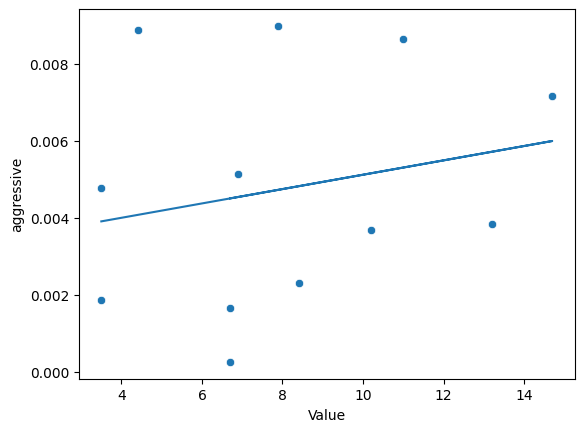

In [37]:
sns.scatterplot(data=df_master1,x= 'Value',y= 'aggressive')
plt.plot(df_master1['Value'], predicion)